# Data Analysis

In [38]:
# импортируем библиотеки
import re
import collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8,5

Populating the interactive namespace from numpy and matplotlib


In [2]:
# загружаем данные
df = pd.read_json('moscow_vacs.json')

In [3]:
# удаляем лишнюю информацию
labels = ['address', 'accept_handicapped', 'accept_kids', 'allow_messages', 'apply_alternate_url', 'area', \
         'archived', 'branded_description', 'billing_type', 'code', 'contacts', 'department', 'employment', \
         'errors', 'hidden', 'id', 'negotiations_url', 'premium', 'quick_responses_allowed', 'relations', \
         'response_letter_required', 'response_url', 'site', 'suitable_resumes_url', 'test', 'type']
df_corr = df.drop(labels, 1)
df_corr.head()

alternate_url          created_at  \
0  https://hh.ru/vacancy/22609856 2017-09-14 07:12:31   
1  https://hh.ru/vacancy/22499032 2017-08-25 12:44:47   
2  https://hh.ru/vacancy/12261627 2017-09-13 14:55:40   
3  https://hh.ru/vacancy/22481569 2017-09-05 16:35:46   
4  https://hh.ru/vacancy/22518640 2017-09-07 13:33:01   

                                         description  \
0  <p><strong>Обязанности:</strong></p> <ul> <li>...   
1  <p><strong>Responsibilities:</strong></p> <ul>...   
2  <p><strong>ПАО «Отисифарм»</strong> — компания...   
3  <p>Delivery Club ― это сервис поиска и заказа ...   
4  <p>Ведущей российской компании, лидеру рынка п...   

                                            employer  \
0  {'logo_urls': {'90': 'https://hhcdn.ru/employe...   
1  {'logo_urls': {'90': 'https://hhcdn.ru/employe...   
2  {'logo_urls': {'90': 'https://hhcdn.ru/employe...   
3  {'logo_urls': {'90': 'https://hhcdn.ru/employe...   
4  {'logo_urls': {'90': 'https://hhcdn.ru/employe...   

                                          experience  \
0  {'id': 'between1And3', 'name': 'От 1 года до 3...   
1    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   
2    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   
3        {'id': 'noExperience', 'name': 'Нет опыта'}   
4    {'id': 'between3And6', 'name': 'От 3 до 6 лет'}   

                     key_skills                                          name  \
0  [{'name': 'Грамотная речь'}]                              Продакт-менеджер   
1                            []                        ​​​​​​​Product Manager   
2                            []                  Менеджер по препаратам (ОТС)   
3                            []           Менеджер по продукту(Delivery Club)   
4                            []  Бренд менеджер (зоотовары, продукты питания)   

         published_at                                             salary  \
0 2017-09-14 07:12:31  {'to': None, 'gross': True, 'from': 65000, 'cu...   
1 2017-08-25 12:44:47                                               None   
2 2017-09-13 14:55:40                                               None   
3 2017-09-05 16:35:46                                               None   
4 2017-09-07 13:33:01                                               None   

                                   schedule  \
0  {'id': 'fullDay', 'name': 'Полный день'}   
1  {'id': 'fullDay', 'name': 'Полный день'}   
2  {'id': 'fullDay', 'name': 'Полный день'}   
3  {'id': 'fullDay', 'name': 'Полный день'}   
4  {'id': 'fullDay', 'name': 'Полный день'}   

                                     specializations  
0  [{'profarea_id': '18', 'profarea_name': 'Произ...  
1  [{'profarea_id': '3', 'profarea_name': 'Маркет...  
2  [{'profarea_id': '3', 'profarea_name': 'Маркет...  
3  [{'profarea_id': '3', 'profarea_name': 'Маркет...  
4  [{'profarea_id': '17', 'profarea_name': 'Прода...

In [4]:
# в столбце description одна лишняя строка
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068 entries, 0 to 1067
Data columns (total 11 columns):
alternate_url      1067 non-null object
created_at         1067 non-null datetime64[ns]
description        1068 non-null object
employer           1067 non-null object
experience         1067 non-null object
key_skills         1067 non-null object
name               1067 non-null object
published_at       1067 non-null datetime64[ns]
salary             345 non-null object
schedule           1067 non-null object
specializations    1067 non-null object
dtypes: datetime64[ns](2), object(9)
memory usage: 100.1+ KB


In [5]:
# удаляем лишнюю строку
df_corr = df_corr.drop([40])

In [6]:
# в некоторых столбцах данные представлены в виде словаря
experience = df_corr.experience[0]
experience

{'id': 'between1And3', 'name': 'От 1 года до 3 лет'}

In [7]:
# определим ключ, значения по которому нам потребуются
experience = df_corr.experience[0]['name']
experience

'От 1 года до 3 лет'

In [8]:
# сохраним значения по искомому ключу в отдельный столбец
df_corr['exp_name'] = df_corr['experience'].apply(lambda x: x['name'])

In [9]:
# посмотрим на полученные значения
df_corr['exp_name'].value_counts()

От 1 года до 3 лет    488
От 3 до 6 лет         440
Более 6 лет            76
Нет опыта              63
Name: exp_name, dtype: int64

## Отфильтруем сферы бизнеса

In [10]:
# создадим отдельный столбец со сферой бизнеса
df_corr['spec_area'] = df_corr['specializations'].apply(lambda x: x[0]['profarea_name'])

In [11]:
# посмотрим на значения в этом столбце
df_corr['spec_area'].value_counts()

Маркетинг, реклама, PR                                   274
Продажи                                                  230
Информационные технологии, интернет, телеком             182
Банки, инвестиции, лизинг                                 78
Закупки                                                   65
Производство                                              57
Медицина, фармацевтика                                    44
Искусство, развлечения, масс-медиа                        29
Консультирование                                          20
Автомобильный бизнес                                      12
Строительство, недвижимость                               12
Высший менеджмент                                         12
Страхование                                               10
Транспорт, логистика                                       8
Административный персонал                                  7
Начало карьеры, студенты                                   5
Управление персоналом, т

In [12]:
# создадим новый датафрейм с данными из сферы айти
df_it = df_corr[(df_corr['spec_area'] == 'Информационные технологии, интернет, телеком')]

In [13]:
# посмотрим на названия вакансий
df_it['name'].value_counts()

Системный аналитик                                                    3
Product manager                                                       3
Менеджер продукта                                                     2
Продакт-менеджер                                                      2
Аналитик                                                              2
Product Manager                                                       2
Менеджер по продукту                                                  2
Системный аналитик в сфере телекоммуникаций                           1
Mobile React Native developer                                         1
Product manager VAS/Менеджер по VAS продуктам (b2с)                   1
Product Manager (Менеджер продукта)                                   1
Project Manager / Product Owner                                       1
Менеджер по развитию ПО (Product Manager/Product owner)               1
Senior Web Analyst                                              

In [50]:
# отфильтруем лишние
name = ['Product manager', 'Продакт', 'продукта', 'по продукту', 'продуктов']
df_it_pm = df_it[df_it['name'].str.contains('|'.join(name), flags=re.IGNORECASE)]
df_it_pm

alternate_url          created_at  \
8         https://hh.ru/vacancy/20971518 2017-08-28 06:38:14   
47        https://hh.ru/vacancy/22708753 2017-09-12 16:35:05   
55        https://hh.ru/vacancy/22540909 2017-08-29 17:00:42   
96        https://hh.ru/vacancy/22750886 2017-09-15 12:17:59   
105       https://hh.ru/vacancy/19912595 2017-09-05 11:06:26   
108       https://hh.ru/vacancy/20311975 2017-09-13 11:34:28   
113       https://hh.ru/vacancy/22412569 2017-09-11 06:00:20   
135       https://hh.ru/vacancy/22391013 2017-08-17 09:14:36   
136       https://hh.ru/vacancy/22526049 2017-08-29 06:17:20   
152       https://hh.ru/vacancy/21325536 2017-09-11 11:13:55   
164       https://hh.ru/vacancy/22537055 2017-08-29 12:32:43   
173       https://hh.ru/vacancy/22622197 2017-09-05 14:40:55   
175       https://hh.ru/vacancy/22090278 2017-08-31 09:12:22   
189       https://hh.ru/vacancy/22562869 2017-08-31 09:29:14   
193       https://hh.ru/vacancy/20848004 2017-08-31 07:52:21   
199       https://hh.ru/vacancy/19912371 2017-09-05 11:06:30   
201       https://hh.ru/vacancy/22419474 2017-09-14 06:24:58   
210       https://hh.ru/vacancy/22430413 2017-08-21 10:11:40   
228       https://hh.ru/vacancy/21895629 2017-09-11 05:32:02   
231       https://hh.ru/vacancy/20649590 2017-09-11 10:16:07   
255       https://hh.ru/vacancy/22455587 2017-08-22 14:28:25   
264       https://hh.ru/vacancy/14427343 2017-09-14 08:53:33   
295       https://hh.ru/vacancy/22304433 2017-09-05 07:59:19   
296       https://hh.ru/vacancy/22376789 2017-09-15 11:01:49   
304       https://hh.ru/vacancy/20962882 2017-09-05 08:03:26   
337       https://hh.ru/vacancy/22059087 2017-09-07 15:17:44   
340       https://hh.ru/vacancy/22409211 2017-08-18 12:23:47   
347       https://hh.ru/vacancy/20230220 2017-08-31 08:00:18   
368       https://hh.ru/vacancy/22537108 2017-08-29 12:33:14   
410       https://hh.ru/vacancy/22027918 2017-08-18 06:46:28   
...                                  ...                 ...   
646       https://hh.ru/vacancy/22013038 2017-09-07 07:25:36   
663       https://hh.ru/vacancy/22604779 2017-09-04 15:14:44   
675       https://hh.ru/vacancy/22562098 2017-09-14 08:31:39   
682       https://hh.ru/vacancy/22501658 2017-08-25 15:54:38   
710       https://hh.ru/vacancy/22639007 2017-09-12 15:01:09   
746       https://hh.ru/vacancy/19957156 2017-09-11 10:09:37   
750       https://hh.ru/vacancy/16471625 2017-09-05 11:06:33   
759       https://hh.ru/vacancy/21957655 2017-09-15 08:36:17   
772       https://hh.ru/vacancy/22562622 2017-08-31 09:19:26   
802       https://hh.ru/vacancy/22716117 2017-09-13 09:02:02   
807       https://hh.ru/vacancy/22488393 2017-08-24 16:09:00   
823       https://hh.ru/vacancy/20122676 2017-09-11 08:05:13   
832       https://hh.ru/vacancy/21060091 2017-09-13 11:34:28   
845       https://hh.ru/vacancy/21502012 2017-09-11 05:32:02   
848       https://hh.ru/vacancy/22734264 2017-09-14 10:25:50   
850       https://hh.ru/vacancy/22453282 2017-08-22 12:41:36   
852       https://hh.ru/vacancy/22488505 2017-09-14 16:34:39   
853       https://hh.ru/vacancy/20431217 2017-09-12 12:32:27   
860       https://hh.ru/vacancy/22211651 2017-08-29 07:38:36   
903       https://hh.ru/vacancy/21029180 2017-08-24 07:22:29   
904       https://hh.ru/vacancy/22498429 2017-09-15 12:10:42   
914       https://hh.ru/vacancy/22154837 2017-08-29 07:36:35   
915       https://hh.ru/vacancy/22063168 2017-09-11 14:37:30   
927       https://hh.ru/vacancy/21915272 2017-08-28 08:09:15   
933       https://hh.ru/vacancy/22269050 2017-09-11 10:47:58   
975       https://hh.ru/vacancy/22376264 2017-09-11 11:04:32   
979       https://hh.ru/vacancy/22504569 2017-08-27 18:39:56   
984       https://hh.ru/vacancy/22612636 2017-09-05 08:39:15   
990   https://career.ru/vacancy/22055683 2017-09-14 15:58:41   
1009      https://hh.ru/vacancy/22731359 2017-09-14 08:26:11   

                                            description  \

In [53]:
df_it_pm.name.value_counts()

Product manager                                                         3
Менеджер по продукту                                                    2
Product Manager                                                         2
Менеджер продукта                                                       2
Продакт-менеджер                                                        2
Менеджер по продажам программных продуктов (без поиска)                 1
Менеджер по продукту (Internet of things)                               1
Продуктовый аналитик                                                    1
Продакт-менеджер (Энергетика/ИБП)                                       1
UC&VC presales product manager                                          1
Product manager (hardware)                                              1
Сервис-менеджер по продуктам ИБ                                         1
Менеджер по продукту (product manager) - линейка СХД                    1
Менеджер по продукту (облачные сервисы

In [54]:
df_it_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 8 to 1009
Data columns (total 13 columns):
alternate_url      79 non-null object
created_at         79 non-null datetime64[ns]
description        79 non-null object
employer           79 non-null object
experience         79 non-null object
key_skills         79 non-null object
name               79 non-null object
published_at       79 non-null datetime64[ns]
salary             16 non-null object
schedule           79 non-null object
specializations    79 non-null object
exp_name           79 non-null object
spec_area          79 non-null object
dtypes: datetime64[ns](2), object(11)
memory usage: 8.6+ KB


## Частотный список

In [15]:
# возьмем одну вакансию для примера
df_it['name'][8]

'Менеджер по продукту'

In [16]:
# посмотрим на ее описание
df_it['description'][8]

'<p><strong>Компания </strong><strong>Mirapolis</strong><strong> (входит в ГК &quot;</strong><strong>Softline</strong><strong>&quot;) приглашает к длительному сотрудничеству </strong><strong>P</strong><strong>roduct-менеджера</strong></p> <p> </p> <p><strong>Обязанности:</strong></p> <ul> <li>Проектирование и развитие функциональности программного продукта.</li> <li>Изучение и анализ конкурентных решений западных и российских разработчиков и формирование ТЗ на новую функциональность.</li> <li>Анализ текущей функциональности системы на предмет развития и повышения удобства.</li> <li>Сбор обратной связи от пользователей продукта.</li> <li>Проектирование новой функциональности, постановка задач разработчикам.</li> <li>Контроль правильности создания новых возможностей.</li> <li>Определение приоритетных направлений развития продукта, формирование планов развития продукта.</li> <li>Участие в ведении community продукта.</li> </ul> <p> </p> <p><strong>Обязательные</strong> <strong>требования:<

In [17]:
# функция должна возвращать пары (слово, частота), отсортированные по частоте в порядке убывания
def get_freq_list(texts):
    words = collections.defaultdict(int)
    for text in texts:
        for word in re.split(r'\W', text):
            words[word.lower()] += 1
    del words[u'']
    
    return [(word, words[word]) for word in sorted(words, key=lambda w: words[w], reverse=True)]

In [18]:
get_freq_list(df_it.description)

[('li', 7505),
 ('p', 4040),
 ('и', 1939),
 ('strong', 1841),
 ('в', 1194),
 ('ul', 1188),
 ('and', 1036),
 ('с', 611),
 ('по', 491),
 ('to', 486),
 ('the', 453),
 ('на', 442),
 ('in', 442),
 ('of', 442),
 ('опыт', 380),
 ('работы', 340),
 ('a', 335),
 ('br', 284),
 ('для', 283),
 ('with', 282),
 ('experience', 222),
 ('мы', 218),
 ('for', 209),
 ('от', 200),
 ('product', 196),
 ('продуктов', 191),
 ('знание', 176),
 ('компании', 168),
 ('is', 166),
 ('продукта', 161),
 ('к', 158),
 ('разработки', 157),
 ('не', 133),
 ('on', 133),
 ('we', 131),
 ('участие', 117),
 ('our', 116),
 ('development', 116),
 ('требования', 111),
 ('or', 110),
 ('em', 109),
 ('as', 109),
 ('бизнес', 108),
 ('или', 107),
 ('it', 107),
 ('team', 105),
 ('business', 104),
 ('проектов', 101),
 ('you', 97),
 ('work', 97),
 ('skills', 96),
 ('умение', 95),
 ('за', 95),
 ('что', 95),
 ('management', 95),
 ('понимание', 91),
 ('как', 89),
 ('работа', 89),
 ('are', 89),
 ('требований', 86),
 ('be', 86),
 ('project', 85

## Bag of Words

In [19]:
vect = CountVectorizer(ngram_range=(1,2), max_df=0.4)

In [55]:
bag = vect.fit_transform(df_it_pm['description'])

In [56]:
vect.vocabulary_

{'компания': 9333,
 'mirapolis': 2858,
 'входит': 6323,
 'гк': 6601,
 'quot': 3427,
 'softline': 3779,
 'приглашает': 14025,
 'длительному': 7033,
 'сотрудничеству': 17107,
 'roduct': 3592,
 'менеджера': 10315,
 'проектирование': 14728,
 'развитие': 15362,
 'функциональности': 18901,
 'программного': 14302,
 'изучение': 8250,
 'анализ': 4975,
 'конкурентных': 9476,
 'решений': 15918,
 'западных': 7865,
 'российских': 16018,
 'разработчиков': 15606,
 'формирование': 18819,
 'тз': 17971,
 'новую': 11410,
 'функциональность': 18909,
 'текущей': 17701,
 'системы': 16676,
 'предмет': 13843,
 'повышения': 13059,
 'удобства': 18266,
 'сбор': 16285,
 'обратной': 11655,
 'связи': 16386,
 'пользователей': 13418,
 'новой': 11396,
 'постановка': 13651,
 'задач': 7686,
 'разработчикам': 15592,
 'контроль': 9566,
 'правильности': 13767,
 'создания': 16993,
 'новых': 11425,
 'возможностей': 6122,
 'определение': 11943,
 'приоритетных': 14153,
 'направлений': 11064,
 'планов': 12829,
 'участие': 18642

In [57]:
vect.stop_words_

{'li',
 'li li',
 'li ul',
 'li знание',
 'li опыт',
 'strong',
 'strong ul',
 'strong обязанности',
 'strong требования',
 'strong условия',
 'ul',
 'ul li',
 'ul strong',
 'бизнес',
 'для',
 'знание',
 'компании',
 'лет',
 'мы',
 'на',
 'обязанности',
 'обязанности strong',
 'опыт',
 'опыт работы',
 'от',
 'офис',
 'по',
 'понимание',
 'продукта',
 'продуктов',
 'работы',
 'развития',
 'тк',
 'требования',
 'требования strong',
 'условия'}

In [58]:
vctr_tfidf = TfidfTransformer()

In [59]:
td_bag = vctr_tfidf.fit_transform(bag)

In [60]:
vctr_tfidf.idf_

array([ 2.74296931,  3.99573227,  4.68887945, ...,  4.68887945,
        4.68887945,  4.68887945])

## NTLK

In [26]:
def get_popular_phrase(text, len, count_phrases):
    phrase_counter = Counter()
    words = nltk.word_tokenize(text.lower())

    for phrase in nltk.ngrams(words, len):
        if all(word not in string.punctuation for word in phrase):
            phrase_counter[phrase] += 1

    return phrase_counter.most_common(count_phrases)

    descriptions = df_it['description']

    text = ''

    for description in descriptions:
            text = text + description[0]

    result = get_popular_phrase(text, 1, 20)
    for r in result:
        print(" ".join(r[0]) + " - " + str(r[1]))

In [27]:
def main():
    descriprions = df_it['description']

    text = ''

    for descriprion in descriprions:
            text = text + descriprion[0]

    result = get_popular_phrase(text, 4, 20)
    for r in result:
        print(" ".join(r[0]) + " - " + str(r[1]))

main()

< < < < - 171
< < < н - 1
< < н < - 1
< н < < - 1
н < < < - 1
< < < р - 1
< < р < - 1
< р < < - 1
р < < < - 1


## Проанализируем зарплаты

In [67]:
df_sal = df_it.dropna(axis=0)

In [68]:
df_corr.salary[0]

{'currency': 'RUR', 'from': 65000, 'gross': True, 'to': None}

In [69]:
df_sal['sal_from'] = df_sal['salary'].apply(lambda x: x['from'])

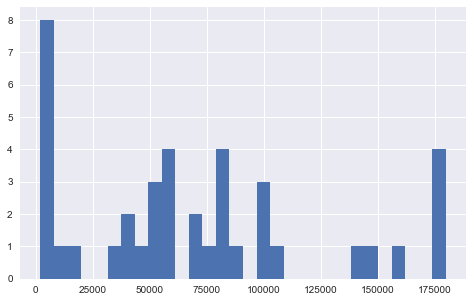

In [70]:
ax = df_sal['sal_from'].hist(bins=30)

In [71]:
df_sal['sal_from'].value_counts()

60000     4
80000     4
50000     3
100000    3
180000    3
5000      3
40000     2
70000     2
3300      2
45000     1
90000     1
2000      1
3760      1
175000    1
140000    1
4000      1
35000     1
15000     1
160000    1
105000    1
8000      1
150000    1
75000     1
Name: sal_from, dtype: int64